# Once the buckets are defined, the next step is to perform the feature selection.

In building a skorecard model, there are few recommended steps to felect the features.

- Calculate the information values (IV) to identify the very predictive features
- Calculate the Population Stability Index (PSI) to identify the unstable features
- Evaluate the multicollinearity of the features that pass the previous two steps


## The information value IV
The information value is defined by the following equation


$$IV = \sum_{i}(\%n_{i}^{y=0} - \%n_{i}^{y=1})\frac{\%n_{i}^{y=0}}{\%n_{i}^{y=1}}$$

where $i$ is the bucket index, $\%n_{i}^{y=0}$ represents the fraction counts of target 0 in the bucket, while $\%n_{i}^{y=1}$ represents the fraction of the counts of target 1 in the bucket $i$.

The IV is a weighted sum of the Weighte of Evidences (WoE) of every bin.<br>
The higher the value, the larger the separation between the classes: in other word the more predictive the feature is.
As a rule of thumbs:
- IV<0.02 non predictive features
- 0.02 < IV < 0.1 predictive feature
- IV > 0.1 very predictive feature

## The Population Stability index (PSI)
The PSI measures the similarity between two samples. The PSI is defined as


$$PSI = \sum_{i}(\%n_{i}^{X1} - \%n_{i}^{X2})\frac{\%n_{i}^{X1}}{\%n_{i}^{X2}}$$


where $i$ is the bucket index, $\%n_{i}^{X1}$ represents the fraction counts of the feature in the sample X1 , while $\%n_{i}^{y=1}$ represents the fraction counts of the feature in the sample X2 in the bucket $i$.
It's the same definition as in the IV. However, here large values indicate a difference between two samples, therefore for the selection we look at the lower values:
- IV < 0.02 stable features
- 0.02 < IV < 0.1 unstable, but acceptable, feature
- IV > 0.1 unstable feature

Let's load the data as in the previous tutorials.

In [1]:
import pandas as pd
from skorecard.datasets import load_credit_card

data = load_credit_card(as_frame=True)

And split it into train and test data

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['y'], axis=1),
    data['y'], 
    test_size=0.25, 
    random_state=42
)

## Load the saved buckets

In [3]:
import yaml

buckets_dict = yaml.safe_load(open("buckets.yml",'r'))


Define the bucketer, using the `UserInputBucketer`

In [4]:
from skorecard.bucketers import UserInputBucketer

uib = UserInputBucketer(buckets_dict)

In [5]:
X_train_bins = uib.fit_transform(X_train,y_train)
X_test_bins = uib.transform(X_test)

In [6]:
X_train_bins

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
21177,2,1,2,0,1,1,0,0,0,0,...,0,0,3,3,1,1,1,2,2,2
23942,0,1,1,0,0,1,0,0,0,0,...,0,0,2,2,1,1,1,3,2,1
1247,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
23622,2,0,1,1,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28454,0,0,1,0,2,1,0,0,0,0,...,0,0,2,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,-3,1,1,0,1,1,0,0,0,0,...,0,0,2,1,1,1,1,1,1,3
5390,2,1,0,0,2,3,1,1,1,1,...,0,0,3,3,2,2,0,3,2,2
860,-3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15795,0,0,1,0,0,1,0,0,0,1,...,0,0,2,2,1,1,1,1,0,1


In [7]:
uib.bucket_table('x1')

,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-3,Special: special_demo,2510.0,11.16,1848.0,662.0,0.263745,-0.224,-0.006
1,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
2,0,"[-inf, 75000.0)",4399.0,19.55,2880.0,1519.0,0.345306,-0.611,-0.085
3,1,"[75000.0, 145000.0)",4567.0,20.30,3494.0,1073.0,0.234946,-0.070,-0.001
4,2,"[145000.0, 375000.0)",9230.0,41.02,7685.0,1545.0,0.167389,0.354,-0.046
5,3,"[375000.0, inf)",1794.0,7.97,1584.0,210.0,0.117057,0.770,-0.037


### Calculating the Information Value

The information value can be calculated by the `iv` function in the reporting module.


In [8]:
from skorecard.reporting import iv

iv_dict = iv(X_train_bins, y_train)

iv_values = pd.Series(iv_dict).sort_values(ascending=False) # sort them by predicting power
iv_values.head(5)

x6     0.881380
x7     0.567571
x8     0.431407
x9     0.370131
x10    0.333630
dtype: float64

Using the definitions from the beginning of this tutorial, we can select the features where the IV values is above 0.02

In [9]:
preselected_features = iv_values[iv_values > 0.02].index.tolist()
print(f"Total selected features by IV: {len(preselected_features)}")

Total selected features by IV: 16


## Calculate the PSI

Similar to the IV, by using the `psi` function in the report module.


In [10]:
from skorecard.reporting import psi
psi_dict = psi(X_train_bins, X_test_bins)

psi_values = pd.Series(psi_dict)
psi_values.sort_values(ascending=False).head(5)

x6     0.000996
x2     0.000702
x12    0.000697
x19    0.000443
x21    0.000357
dtype: float64

In this particular case, all the features have a very low PSI, hence no instability is present and no feature selection is performed.

## Removing multi-collinear features

A skorecard model is based on a logistic regression algorithm.<br>
Logistic regression suffers from multi-collinearity (i.e. highly correlated features) by design.<br>

There are multiple ways of measuring it (VIF, correlations)...<br> 

Here we are showing the approach with correlations.<br>

First, let's build an easy visualization function

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


def plot_correlations(corr):
    plt.figure(figsize=(10, 8), constrained_layout=True)

    cmap = plt.cm.get_cmap("RdBu")
    matrix = np.triu(corr)
    sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix, cmap=cmap, annot_kws={"fontsize": 6})

### Adding the WoE Encoder

A default scorecard model is defined by the following steps:
- bucketing
- encoder (a default one is a WoE encoder)
- logistic regression model

As the input of the logistic regression model is the dataset transformed to its Woe, first let's build the pipline with the first two steps and transform the dataseet

In [12]:
from skorecard.preprocessing import WoeEncoder
from sklearn.pipeline import make_pipeline
woe_pipe = make_pipeline(
    uib,
    WoeEncoder()
)

In [13]:
X_train_woe = woe_pipe.fit_transform(X_train, y_train)

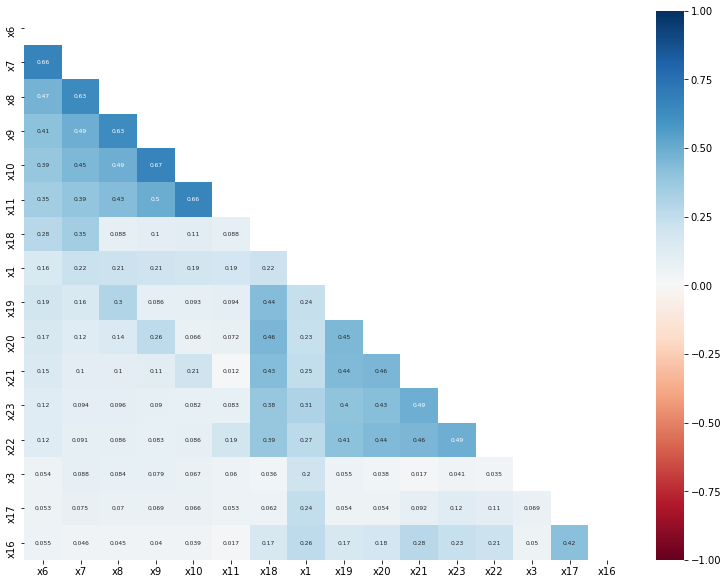

In [14]:
X_train_corr = X_train_woe[preselected_features].corr()
plot_correlations(X_train_corr)

As a rule of thumb, correlations above 0.6 can be considered problematic for the logisitc regression model (this threshold might depend heeavily on dataset and use case).<br>

The following code snippet illustrates a recursive feature elimination step, where features are sorted by their IV importance, and correlated features with lower IV importance are removed

In [15]:
corr_limit = 0.6 # correlation threshold

drop_feats =list()

# keep_feats = list()

for ix, feature in enumerate(preselected_features):
    if feature in drop_feats: continue
    
    remaining_features = [feat for feat in preselected_features[ix:] #check the next feature in the preselected step
                          if feat not in drop_feats and feat!=feature
                         ]
    if len(remaining_features)==0: continue # go to the next step if the features at step x have already been removeed
   
    # find the correlated features with the remaining preselected features
    # both positive and negative correlations matter, hence the abs()
    corr_feats = X_train_corr.loc[remaining_features,feature].apply(lambda x: abs(x))
    
    drop_at_step = corr_feats[corr_feats>corr_limit].index.tolist()
    
    # append the new features to the list
    drop_feats+= drop_at_step

# Select thee features with low correlations
good_feats = [feat for feat in preselected_features if feat not in drop_feats]

print(f"Total preselected features: {len(preselected_features)}")
print(f"Total features dropped due too high correlations: {len(drop_feats)}")
print(f"Total selected features: {len(good_feats)}")

Total preselected features: 16
Total features dropped due too high correlations: 3
Total selected features: 13


Visualizing the correlation of the good features to verify that the RFE step worked

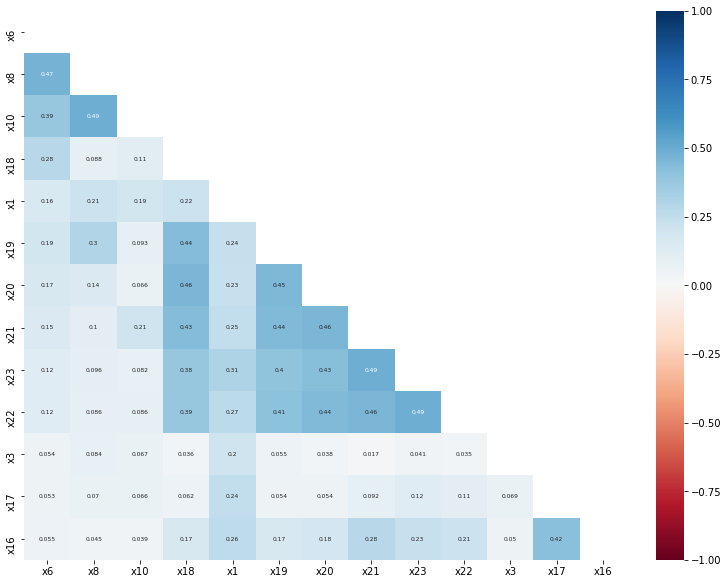

In [16]:
plot_correlations(X_train_woe[good_feats].corr())

and the final list of selected features is shown below

In [17]:
good_feats

['x6',
 'x8',
 'x10',
 'x18',
 'x1',
 'x19',
 'x20',
 'x21',
 'x23',
 'x22',
 'x3',
 'x17',
 'x16']

## Up next

After performing the feature selection, it's time to build the final `Skorecard` model.
